In [59]:
import evaluation.score_acculumator as score_accumulator
import evaluation.plotting_utils as plot_utils
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from tqdm import tqdm
import json, os, sys, copy


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" # change this to change gpu number

import torch
print(torch.cuda.get_device_name(torch.cuda.current_device()))

%load_ext autoreload
%autoreload 2

NVIDIA TITAN Xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Embedding similarity analysis

Run the following code segments to generate an similarity analysis of full-song embeddings. The embeddings require access to a gpu to run at a reasonable speed.

In [50]:
########### Download the model and read in the prediction data ########
embedding_model = SentenceTransformer('all-mpnet-base-v2')
model_outputs = [
    "data/model_outputs/llama-2-7b-chat-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs.json"
]
model_names = [
    "llama",
    "lyre_50",
    "lyre_100",
    "lyre_150",
    "lyre_100_temp1",
    "lyre_150_temp1",
]
colors = ['brown', 'lightcoral', 'mediumorchid', "indianred", 'blue', 'black'] 

ground_truth =  pd.read_json(model_outputs[0], orient="records")['target_response'].to_list()
for i, path in enumerate(model_outputs):
    model_outputs[i] = pd.read_json(path, orient="records")['model_response'].to_list()



In [51]:
def embed_songs(embedding_model, songlist, name=''):
    embedded = np.stack([embedding_model.encode(song) for song in tqdm(songlist, "Embedding "+name)])
    return embedded

def compute_similarity(all_model_embeddings, target_embeddings, names, pca=0):
    norm = lambda x: x / np.linalg.norm(x)
    transform = lambda x: x
    if pca > 0:
        comp = PCA(n_components=pca)
        target_embeddings = comp.fit_transform(target_embeddings)
        transform = lambda x: comp.transform(x)
    similarity_scores = {n: 0 for n in names}
    for i, embedding in enumerate(all_model_embeddings):
        emb = transform(embedding)
        scores = [np.dot(norm(emb[j]), norm(target_embeddings[j])) for j in tqdm(list(range(emb.shape[0])), "Scoring " +names[i])]
        similarity_scores[names[i]] = np.mean(scores)
    return similarity_scores

In [52]:
target_embeddings = embed_songs(embedding_model, ground_truth, "target")
all_embeddings = [embed_songs(embedding_model, model_outputs[i], model_names[i]) for i in range(len(model_outputs))]

Embedding lyre_150_temp1: 100%|██████████| 117/117 [00:04<00:00, 27.96it/s]


In [53]:
similarity_scores = compute_similarity(all_embeddings, target_embeddings, model_names, pca=4)

Scoring lyre_150_temp1: 100%|██████████| 117/117 [00:00<00:00, 30716.92it/s]


In [54]:
print(similarity_scores)

{'llama': 0.58902186, 'lyre_50': 0.5929036, 'lyre_100': 0.6142979, 'lyre_150': 0.7316317, 'lyre_100_temp1': 0.6626033, 'lyre_150_temp1': 0.6856372}


# PCA embeddings analysis
Using the SentenceBert embeddings, we can also analyze our model similarities in 3D space via PCA. Use the parameter `cp_offset` to sample different principal component windows, and highlight the differences between the finetuned and the Llama model outputs.

In [55]:
# Compute 10-component PCA
comp = PCA(n_components=10)
pc_offset = 3

# Transform embeddings
t1 = comp.fit_transform(target_embeddings)[:, pc_offset:pc_offset+3]
t_models = [comp.transform(emb)[:, pc_offset:pc_offset+3] for emb in all_embeddings]

plot_utils.plot_3d_centroids([t1] + t_models, ["target"] + model_names, ['darkseagreen'] + colors)

# Musical Structure Analysis
As per section 2.1 of our report, we can evaluate the musical & structural qualities of the finetuned Lyre model's predictions.
We analyze 8 different metrics. For more detail, refer to our report, or take a look at the code under [scoring_metrics.py](evaluation/scoring_metrics.py)

The following lines may take a while, especially if you don't have a powerful GPU. 

Consider **skipping to the next section**, and loading the saved results of the evaluation.

In [56]:
measures = ["diversity", "syllable", "meter", "semantics", "semantics_internal", "string_similarity", "tail_similarity", "head_similarity", "phonetics"]
model_outputs = [
    "data/model_outputs/llama-2-7b-chat-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs.json",
    "data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs.json"
]
model_names = [
    "llama",
    "lyre_50",
    "lyre_100",
    "lyre_150",
    "lyre_100_temp1",
    "lyre_150_temp1",
]
colors = ['brown', 'lightcoral', 'mediumorchid', "indianred", 'blue', 'black'] 


In [96]:
def build_score_accumulators(measures, model_outputs, names):
    accumulators = []
    for path in model_outputs:
        accum = score_accumulator.ScoreAccumulator(measures)
        with open(path, 'r') as f:
            db = json.load(f)
        accum.score_all_songs(db, num_workers=8)
        accumulators.append(accum)
    return accumulators

def find_common_keys_and_prune(databases):
    """
    Takes a list of databases, finds the set of common keys among all of them,
    and prunes any keys that are not shared among all the databases.

    :param dicts: List of dictionaries
    :return: List of dictionaries with only the common keys
    """
    
    if not databases:
        return []

    common_keys = set(databases[0].keys())
    for d in databases[1:]:
        common_keys.intersection_update(d.keys())
    
    # Prune keys that are not in the set of common keys
    pruned_dicts = [{k: d[k] for k in common_keys} for d in databases]

    return pruned_dicts
        


In [58]:
accumulators = build_score_accumulators(measures, model_outputs, model_names)
databases = [accum.get_database() for accum in accumulators]

100%|██████████| 117/117 [01:09<00:00,  1.68it/s]


You may notice that llama has rejected some of the prompts due to its value alignment. To generate a fair comparison, we will prune these from the lyre outputs.

In [103]:
pruned_dbs = find_common_keys_and_prune(databases)

# write databases to original file with "scores" suffix
for i, db in enumerate(pruned_dbs):
    out_name = os.path.splitext(model_outputs[i])[0] + "_scores"+ os.path.splitext(model_outputs[i])[1]
    print(out_name)
    with open(out_name, "w") as f:
        f.write(json.dumps(db, indent = 2, separators=[",",":"]))

data/model_outputs/llama-2-7b-chat-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs_scores.json


### Skip here if you don't want to wait for the metrics to run
You can load metrics from a previously run file.

In [104]:
pruned_dbs = []
for i, fname in enumerate(model_outputs):
    scores_name = os.path.splitext(fname)[0] + "_scores"+ os.path.splitext(fname)[1]
    print(scores_name)
    with open(scores_name, 'r') as f:
        pruned_dbs.append(json.load(f))

data/model_outputs/llama-2-7b-chat-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-50-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-100-temp-1-test-outputs_scores.json
data/model_outputs/lyre-chat-small-batch-checkpoint-150-temp-1-test-outputs_scores.json


In [110]:
def build_all_scores_db(databases, names, measures):
    names = names + ["target"]
    all_scores = {m:{n : [] for n in names} for m in measures}
    
    # extract scores
    gt_scores = [databases[0][id]["target_scores"] for id in databases[0].keys()]
    for i in range(len(databases)):
        databases[i] = [databases[i][id]["pred_scores"] for id in databases[i].keys()]
    databases.append(gt_scores)

    #build all scores database
    for m in measures:
        for i, n in enumerate(names):
            all_scores[m][n] = np.array([song[m] for song in databases[i]])
                
    return all_scores

In [111]:
all_scores = build_all_scores_db(pruned_dbs, model_names, measures)

# map between 0 and 100
measure_scales = []
for m in measures:
    for name in model_names + ["target"]:
        if m != 'diversity':
            all_scores[m][name] = 100 * np.exp(-all_scores[m][name])
        else:
            all_scores[m][name] = 100 * np.exp(all_scores[m][name])

print(f"Measures available: {'  -  '.join(list(all_scores.keys()))}")

Measures available: diversity  -  syllable  -  meter  -  semantics  -  semantics_internal  -  string_similarity  -  tail_similarity  -  head_similarity  -  phonetics


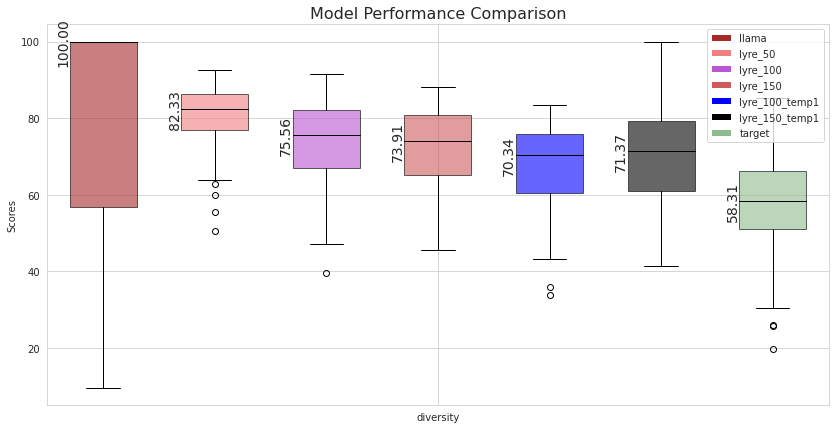

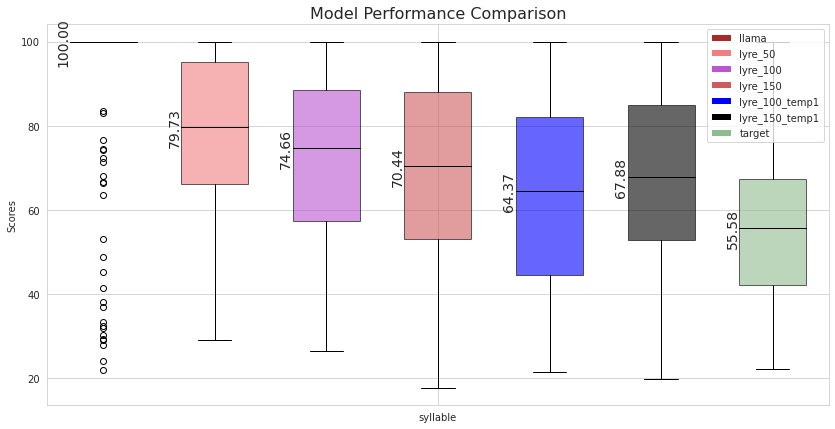

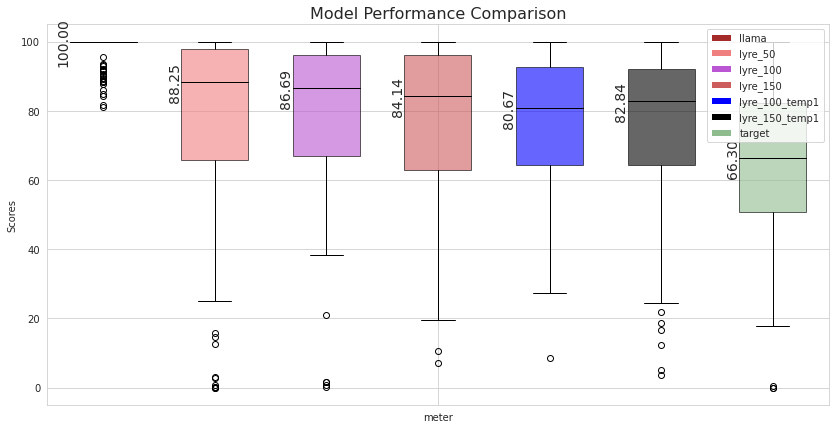

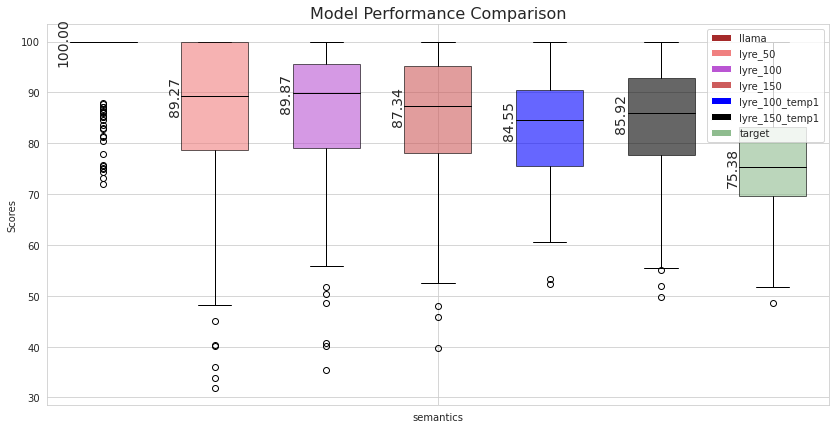

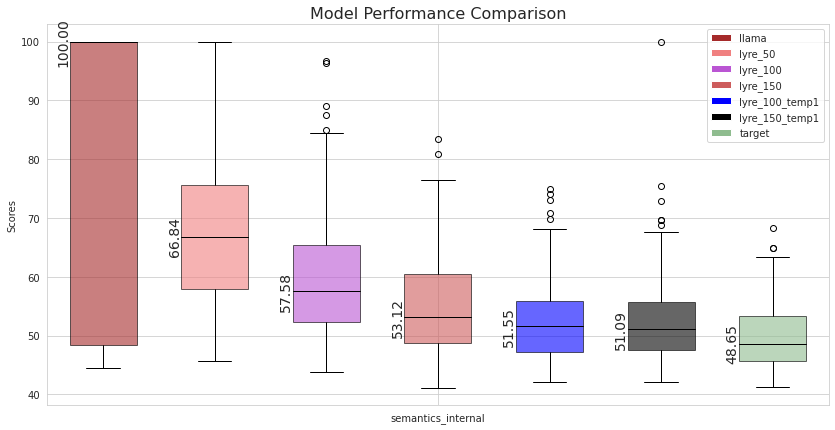

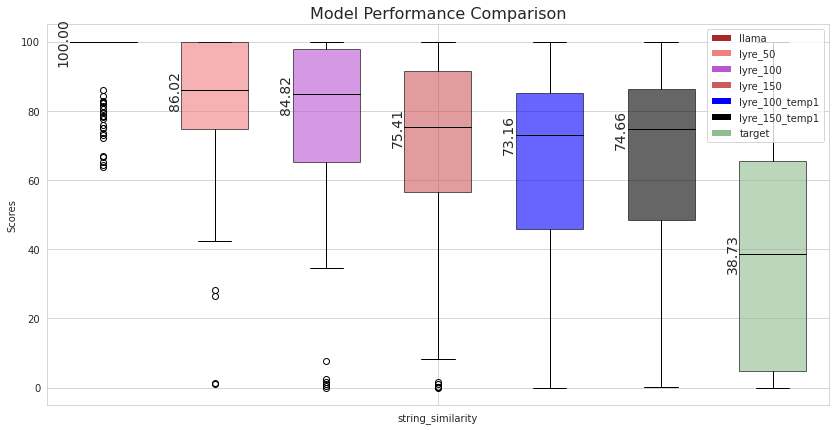

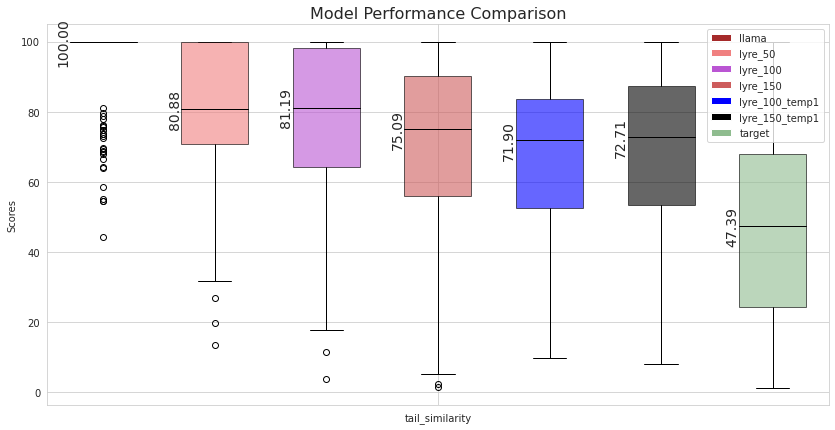

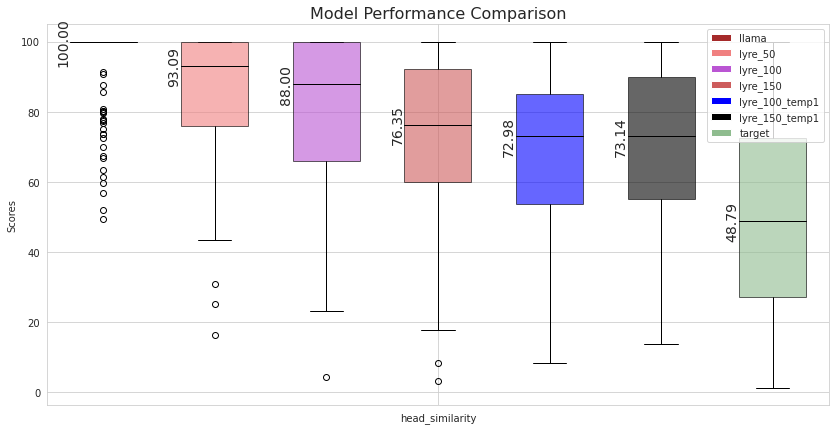

Embedding lyre_150:   0%|          | 0/117 [56:29<?, ?it/s]


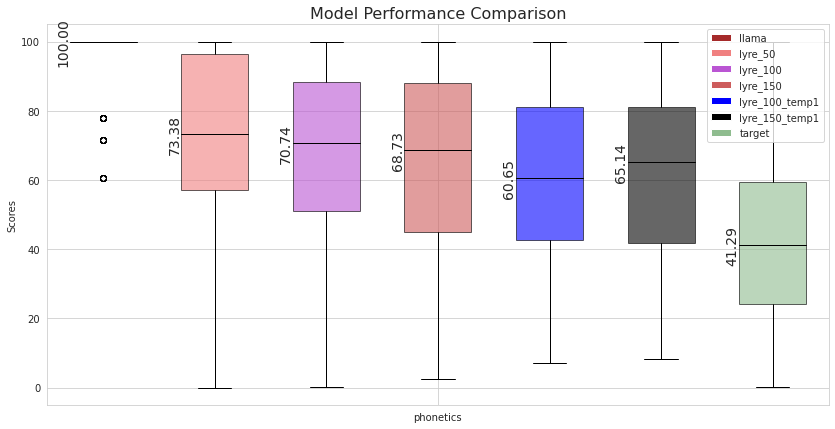

In [124]:
####### Plot measure distributions ########
measures_subset = []  # change this to any subset of the measures
if not measures_subset:
    measures_subset = list(all_scores.keys()) 

for measure in measures_subset:
    plot_utils.measures_boxplot(all_scores, [measure], models=model_names + ["target"], labels=model_names + ["target"], colors=colors + ['darkseagreen'], ylim=None, show_outliers=True)

In [123]:
data = []
for m in measures:
    measure_data = {"Measure": m}
    for name in model_names + ["target"]:
        measure_data[name + " score"] = np.mean(all_scores[m][name])
    
    data.append(measure_data)

df = pd.DataFrame(data)
df = df.round(2)
df = df.sort_values(by='target score', ascending=False)
print(df)

              Measure  llama score  lyre_50 score  lyre_100 score  \
3           semantics        95.95          85.49           85.34   
2               meter        97.67          77.35           78.90   
1            syllable        89.10          77.34           71.75   
0           diversity        80.43          80.42           73.39   
4  semantics_internal        79.56          67.70           60.70   
7     head_similarity        94.09          84.94           81.27   
6     tail_similarity        93.11          79.36           77.39   
8           phonetics        93.63          69.91           67.67   
5   string_similarity        94.77          82.22           77.82   

   lyre_150 score  lyre_100_temp1 score  lyre_150_temp1 score  target score  
3           84.01                 83.03                 83.89         76.39  
2           78.09                 76.79                 75.56         64.46  
1           69.94                 64.05                 68.95         57.92